In [70]:
using Pkg
for p in ["Knet", "Plots", "IterTools"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end
using DelimitedFiles
using Knet: KnetArray, accuracy, progress, minibatch, cycle, adam, sgd
using Plots
using IterTools: ncycle, takenth, take
using Base.Iterators: flatten
using LinearAlgebra

include("utils.jl")
include("models.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


In [71]:
# Load data
adj, features, labels, idx_train, idx_val, idx_test = load()

(Float32[0.166667 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.25], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Int32[0 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 0], 1:140, 200:499, 501:1500)

In [72]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train])

In [73]:
output = model(features)

7×2708 Array{Float32,2}:
  0.00105802  -0.00164994   0.000144585  …   0.00126138   -0.00668703
 -0.00507737   0.00567824  -0.000191399     -4.26627e-5    0.00645913
  2.66343e-5  -0.00129475  -0.000869239     -0.000923322   0.00741185
  0.00249813   0.00321607   0.00526163       0.00680557    0.00258897
 -0.00321316   0.00447089   0.00448901       0.00381716    0.00469275
 -0.00706574  -0.00473304  -0.00627624   …  -0.00920482   -0.00525041
 -0.00483502  -0.00169617   0.000574952     -0.00198668   -0.00399635

In [74]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

2708-element Array{Int64,1}:
 5
 2
 1
 1
 7
 7
 3
 5
 5
 3
 5
 4
 7
 ⋮
 3
 7
 7
 7
 7
 5
 4
 4
 4
 4
 6
 5

In [75]:
nll(output[:,idx_train], labels_decoded[idx_train])

1.9460473f0

In [76]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.12142857142857143

In [77]:
using AutoGrad
J = @diff model(features, labels_decoded)
grad(J, params(model)[1])

16×1433 Array{Float32,2}:
 -4.40644e-6   1.94717e-5    4.02846e-6   …   0.000106319   8.9795e-5  
 -6.54903e-5  -5.09546e-5   -0.000123335     -1.064e-5      3.75506e-5 
  5.89695e-5   3.50539e-5    2.3535e-5        3.58902e-5    0.000101801
  4.07602e-6  -3.64482e-5    3.44573e-5      -1.61376e-5   -7.41268e-6 
 -4.04934e-5  -4.93382e-6    6.81025e-5      -5.73473e-6   -9.71726e-6 
 -6.5945e-5   -2.0458e-5    -4.02155e-5   …   6.2156e-5     1.0122e-5  
  2.07923e-5  -9.19938e-6    2.52633e-7       4.95567e-5    1.80553e-5 
  5.03784e-5  -1.18442e-5    5.66189e-5      -9.96954e-6   -4.45748e-5 
  2.9608e-6   -4.08144e-5    7.40498e-6       3.35841e-5    8.72816e-6 
 -6.91516e-5   6.50139e-5   -2.78268e-5      -5.31178e-5    0.000100861
  1.62455e-5  -3.47452e-5    3.90043e-5   …  -0.000109087  -0.000231742
 -1.80218e-6   1.27863e-5    4.87168e-6       5.68879e-5    0.0        
  2.18987e-5  -0.000118006   0.000227787      6.27554e-5   -2.22526e-5 
  6.43107e-5   9.62749e-6    0.0001390

In [78]:
dtrn =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{Array{Float32,2},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5 2 … 6 5], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), Array{Float32,2}, Array{Int64,1})

In [79]:
function train_with_results(model, dtrn, epoch, lr)
    training = adam(model, ncycle(dtrn, epoch), lr=lr)
    snapshot() = model(dtrn)
    snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
    res = collect(flatten(snapshots))
    return res
end

train_with_results (generic function with 1 method)

┣████████████████████┫ [100.00%, 200/200, 00:18/00:18, 11.35i/s] 


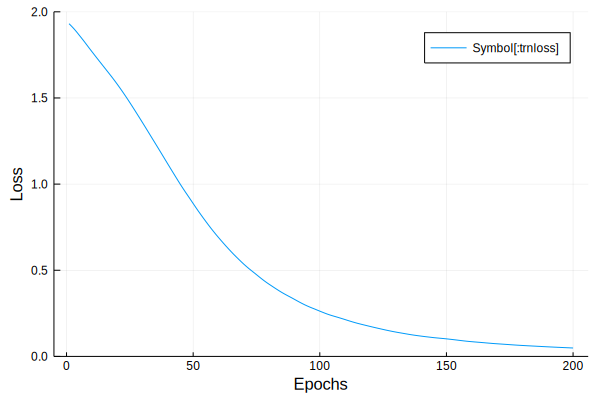

In [80]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [81]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [82]:
output = model(features)
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.8

In [83]:
include("utils2.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


load_dataset (generic function with 1 method)

In [84]:
adj2, features2, labels2, idx_train, idx_val, test_idx_reorder = load_dataset("pubmed")

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 1.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Int32[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 1:140, 200:500, [2692, 2532, 2050, 1715, 2362, 2609, 2622, 1975, 2081, 1767  …  1885, 2305, 2354, 2135, 2601, 1770, 1995, 2504, 1749, 2157])

In [85]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features2,1),
            arguments.hidden,
            size(labels2,2),
            adj2,
            arguments.pdrop)

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
#(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train])

In [86]:
output = model(features2)

7×2708 Array{Float32,2}:
  0.234638   0.591772   0.347029  …   0.183115    1.41044     1.29268 
  0.35971   -0.615776   0.635876     -0.0136887  -0.330138   -0.169687
 -0.275689  -0.531172  -1.07201       0.168053    0.0379852  -1.56499 
 -0.404421   0.481658  -2.36345       0.365021    0.410243    1.04987 
  0.798518   0.50224    1.83745      -0.0326211   1.17741     0.618802
  0.357256   1.91753    1.0624    …   0.254597    2.20057     3.1882  
 -0.716512  -0.903464  -2.20408      -0.225788   -1.68196    -1.25733 

In [87]:
labels_decoded = mapslices(argmax, labels2 ,dims=2)[:]

2708-element Array{Int64,1}:
 4
 5
 5
 1
 4
 3
 1
 4
 4
 3
 1
 1
 5
 ⋮
 4
 4
 4
 4
 4
 4
 1
 4
 4
 4
 4
 4

In [88]:
nll(output[:,idx_train], labels_decoded[idx_train])

3.6363032f0

In [89]:
using AutoGrad
J = @diff model(features2, labels_decoded)
grad(J, params(model)[1])

16×1433 Array{Float64,2}:
 -0.00210876   -0.00505834   -0.0160476    …   0.00851522   0.00646792
  0.144716      0.250144      0.40435          0.13396     -0.0168403 
  0.0116924     0.000959673   0.000460728      0.00637715  -5.3039e-5 
  0.00636338   -0.0288729     0.0155453        0.0115149    0.00996782
 -0.00743387    0.0850566    -0.0147882        0.0299587    0.0160534 
  0.0227699     0.207464      0.166287     …   0.0354434    0.0370907 
  0.000363204  -0.0327287    -0.00630968      -0.00148873  -0.0188724 
 -0.0289293     0.00709535    0.0429834       -0.0132996    0.0159501 
  0.0349938     0.121346      0.156515         0.0207379    0.10544   
 -0.00147922    0.00709017   -0.0271289        0.00585227  -0.0271719 
  0.000839367  -0.0565075     0.0932531    …   0.025376     0.0688625 
 -4.73896e-5    2.49623e-5   -1.28155e-5       0.0308135    1.73254e-6
  0.02044       0.00181872   -0.0066724        0.0654944    0.043975  
  0.0188843     0.113727      0.0304044       -0.00

In [90]:
dtrn =  minibatch(features2, labels_decoded[:], length(labels_decoded))

Data{Tuple{Array{Float32,2},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 5 … 4 4], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), Array{Float32,2}, Array{Int64,1})

In [91]:
function train_with_results(model, dtrn, epoch, lr)
    training = adam(model, ncycle(dtrn, epoch), lr=lr)
    snapshot() = model(dtrn)
    snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
    res = collect(flatten(snapshots))
    return res
end

train_with_results (generic function with 1 method)

┣████████████████████┫ [100.00%, 200/200, 00:24/00:24, 8.24i/s] 


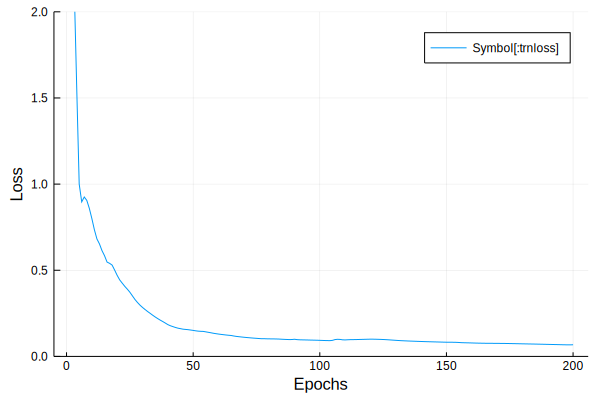

In [92]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [93]:
output = model(features2)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [94]:
output = model(features2)
accuracy(output[:,test_idx_reorder], labels_decoded[test_idx_reorder])

0.739